<a href="https://colab.research.google.com/github/Pietro55555/PRiR/blob/main/Lab12-13/Lab12_13_SeriaWynikow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("photoss.jpg", "https://img.redro.pl/obrazy/flavian-amphitheatre-known-as-the-coliseum-in-rome-italy-700-206994653.jpg")
style_reference_image_path = keras.utils.get_file(
    "styless.jpg", "https://img.redro.pl/obrazy/multi-kolorowe-trojkaty-tlo-vector-700-1966855.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


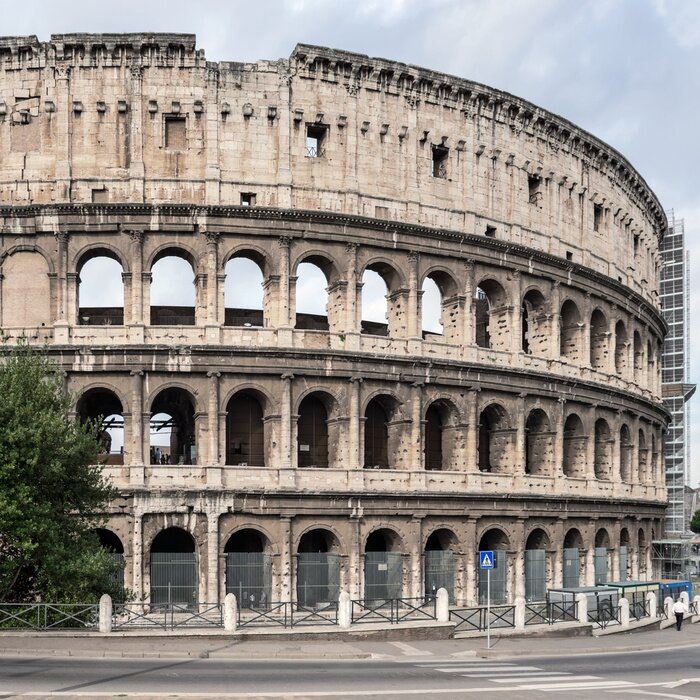

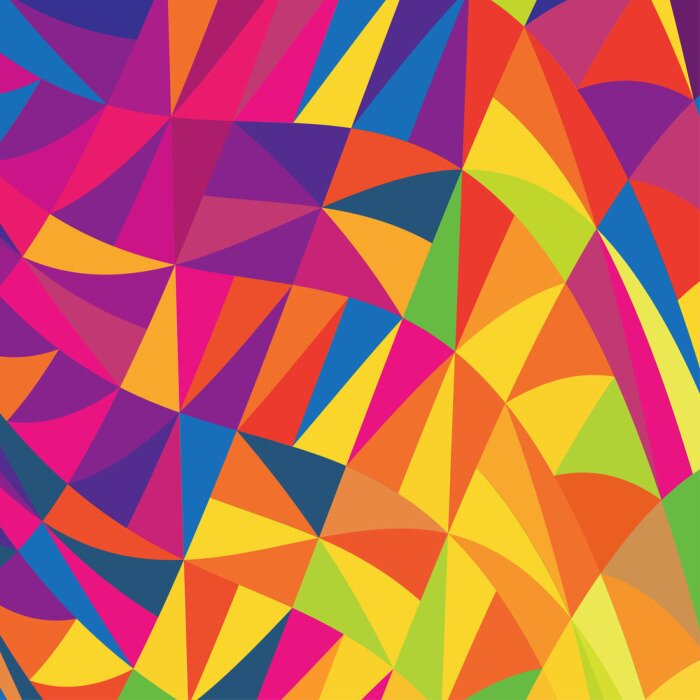

In [50]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))


In [51]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [52]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



In [53]:
 #Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


TUTAJ

In [54]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [55]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [56]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

In [57]:
iterations = 200

Iteration 100: loss=17387.15
Iteration 200: loss=23867.66
Time:  36.92 sek for  200  iterations
Photo name:  paris_generated_at_iteration_200.png


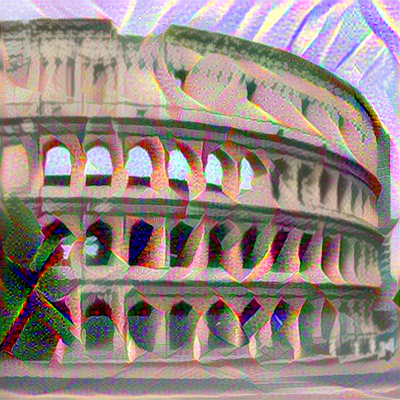

Iteration 100: loss=9315.67
Iteration 200: loss=30737.45
Iteration 300: loss=8933.48
Iteration 400: loss=6740.18
Time:  67.16 sek for  400  iterations
Photo name:  paris_generated_at_iteration_400.png


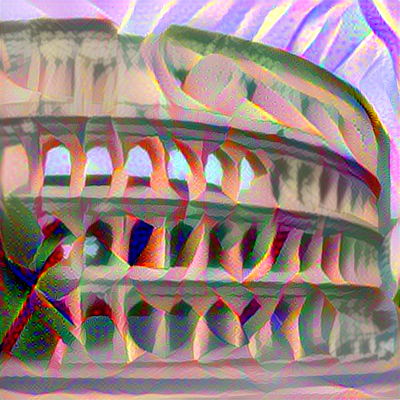

Iteration 100: loss=6753.88
Iteration 200: loss=7659.95
Iteration 300: loss=9370.73
Iteration 400: loss=4546.87
Iteration 500: loss=6008.23
Iteration 600: loss=4352.04
Time:  103.4 sek for  600  iterations
Photo name:  paris_generated_at_iteration_600.png


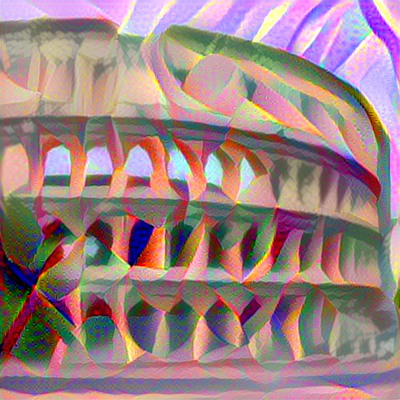

Iteration 100: loss=4032.95
Iteration 200: loss=14745.90
Iteration 300: loss=3708.93
Iteration 400: loss=6382.27
Iteration 500: loss=3360.17
Iteration 600: loss=3178.08
Iteration 700: loss=3103.69
Iteration 800: loss=3074.99
Time:  140.23 sek for  800  iterations
Photo name:  paris_generated_at_iteration_800.png


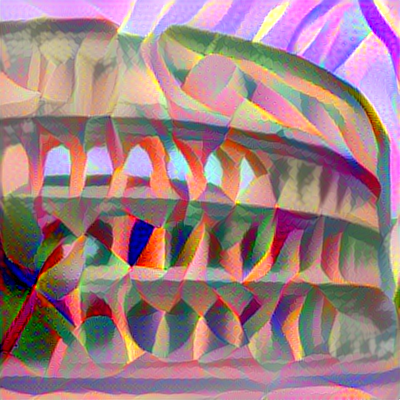

Iteration 100: loss=2891.91
Iteration 200: loss=2951.66
Iteration 300: loss=2762.58
Iteration 400: loss=2741.87
Iteration 500: loss=2693.74
Iteration 600: loss=2611.31
Iteration 700: loss=2579.05
Iteration 800: loss=2547.03
Iteration 900: loss=2496.65
Iteration 1000: loss=2467.69
Time:  176.83 sek for  1000  iterations
Photo name:  paris_generated_at_iteration_1000.png


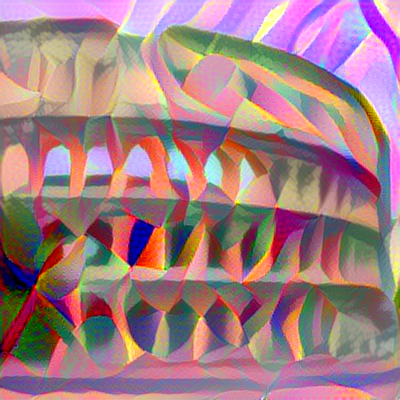

Iteration 100: loss=2433.17
Iteration 200: loss=2403.67
Iteration 300: loss=2376.10
Iteration 400: loss=2350.82
Iteration 500: loss=2327.21
Iteration 600: loss=2305.24
Iteration 700: loss=2284.99
Iteration 800: loss=2266.11
Iteration 900: loss=2248.58
Iteration 1000: loss=2232.24
Iteration 1100: loss=2217.07
Iteration 1200: loss=2202.92
Time:  212.36 sek for  1200  iterations
Photo name:  paris_generated_at_iteration_1200.png


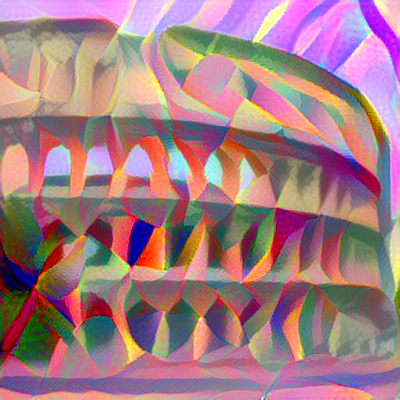

Iteration 100: loss=2189.63
Iteration 200: loss=2177.19
Iteration 300: loss=2165.46
Iteration 400: loss=2154.35
Iteration 500: loss=2143.85
Iteration 600: loss=2133.92
Iteration 700: loss=2124.51
Iteration 800: loss=2115.60
Iteration 900: loss=2107.15
Iteration 1000: loss=2099.09
Iteration 1100: loss=2091.40
Iteration 1200: loss=2084.09
Iteration 1300: loss=2077.19
Iteration 1400: loss=2070.66
Time:  247.99 sek for  1400  iterations
Photo name:  paris_generated_at_iteration_1400.png


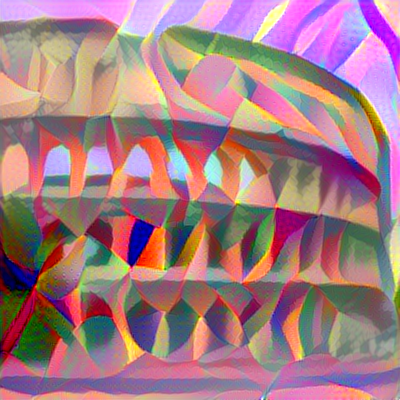

Iteration 100: loss=2064.44
Iteration 200: loss=2058.53
Iteration 300: loss=2052.93
Iteration 400: loss=2047.61
Iteration 500: loss=2042.52
Iteration 600: loss=2037.67
Iteration 700: loss=2033.06
Iteration 800: loss=2028.69
Iteration 900: loss=2024.52
Iteration 1000: loss=2020.54
Iteration 1100: loss=2016.76
Iteration 1200: loss=2013.15
Iteration 1300: loss=2009.70
Iteration 1400: loss=2006.40
Iteration 1500: loss=2003.25
Iteration 1600: loss=2000.24
Time:  283.13 sek for  1600  iterations
Photo name:  paris_generated_at_iteration_1600.png


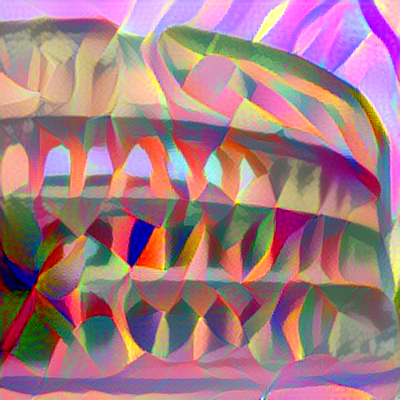

Iteration 100: loss=1997.37
Iteration 200: loss=1994.63
Iteration 300: loss=1992.01
Iteration 400: loss=1989.51
Iteration 500: loss=1987.12
Iteration 600: loss=1984.83
Iteration 700: loss=1982.64
Iteration 800: loss=1980.55
Iteration 900: loss=1978.54
Iteration 1000: loss=1976.62
Iteration 1100: loss=1974.78
Iteration 1200: loss=1973.03
Iteration 1300: loss=1971.34
Iteration 1400: loss=1969.74
Iteration 1500: loss=1968.20
Iteration 1600: loss=1966.73
Iteration 1700: loss=1965.32
Iteration 1800: loss=1963.97
Time:  318.28 sek for  1800  iterations
Photo name:  paris_generated_at_iteration_1800.png


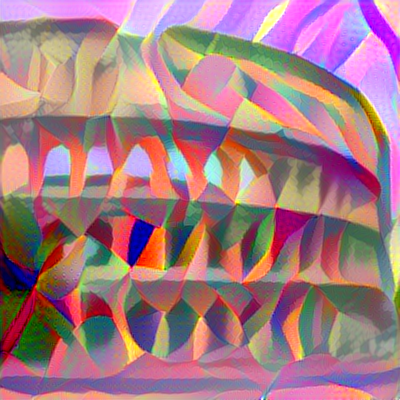

Iteration 100: loss=1962.68
Iteration 200: loss=1961.44
Iteration 300: loss=1960.25
Iteration 400: loss=1959.11
Iteration 500: loss=1958.02
Iteration 600: loss=1956.98
Iteration 700: loss=1955.98
Iteration 800: loss=1955.02
Iteration 900: loss=1954.10
Iteration 1000: loss=1953.21
Iteration 1100: loss=1952.37
Iteration 1200: loss=1951.55
Iteration 1300: loss=1950.78
Iteration 1400: loss=1950.03
Iteration 1500: loss=1949.32
Iteration 1600: loss=1948.63
Iteration 1700: loss=1947.97
Iteration 1800: loss=1947.34
Iteration 1900: loss=1946.73
Iteration 2000: loss=1946.15
Time:  353.93 sek for  2000  iterations
Photo name:  paris_generated_at_iteration_2000.png


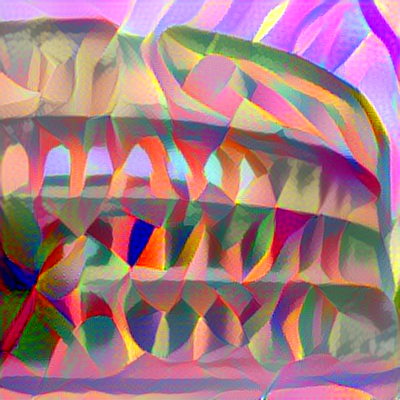

Iteration 100: loss=1945.60
Iteration 200: loss=1945.06
Iteration 300: loss=1944.55
Iteration 400: loss=1944.06
Iteration 500: loss=1943.59
Iteration 600: loss=1943.14
Iteration 700: loss=1942.71
Iteration 800: loss=1942.29
Iteration 900: loss=1941.89
Iteration 1000: loss=1941.51
Iteration 1100: loss=1941.14
Iteration 1200: loss=1940.79
Iteration 1300: loss=1940.45
Iteration 1400: loss=1940.13
Iteration 1500: loss=1939.82
Iteration 1600: loss=1939.52
Iteration 1700: loss=1939.23
Iteration 1800: loss=1938.96
Iteration 1900: loss=1938.69
Iteration 2000: loss=1938.44
Iteration 2100: loss=1938.20
Iteration 2200: loss=1937.96
Time:  389.65 sek for  2200  iterations
Photo name:  paris_generated_at_iteration_2200.png


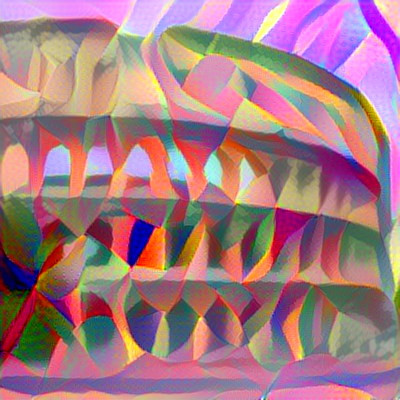

Iteration 100: loss=1937.74
Iteration 200: loss=1937.53
Iteration 300: loss=1937.32
Iteration 400: loss=1937.12
Iteration 500: loss=1936.93
Iteration 600: loss=1936.75
Iteration 700: loss=1936.58
Iteration 800: loss=1936.41
Iteration 900: loss=1936.25
Iteration 1000: loss=1936.10
Iteration 1100: loss=1935.95
Iteration 1200: loss=1935.81
Iteration 1300: loss=1935.67
Iteration 1400: loss=1935.54
Iteration 1500: loss=1935.41
Iteration 1600: loss=1935.29
Iteration 1700: loss=1935.18
Iteration 1800: loss=1935.06
Iteration 1900: loss=1934.96
Iteration 2000: loss=1934.86
Iteration 2100: loss=1934.76
Iteration 2200: loss=1934.66
Iteration 2300: loss=1934.57
Iteration 2400: loss=1934.49
Time:  425.05 sek for  2400  iterations
Photo name:  paris_generated_at_iteration_2400.png


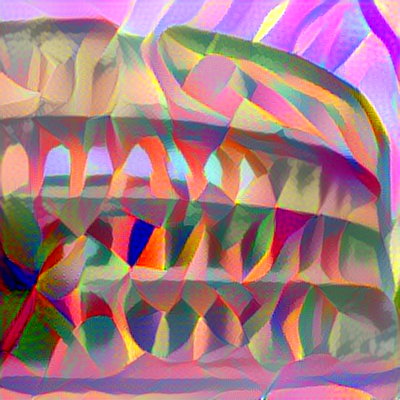

Iteration 100: loss=1934.40
Iteration 200: loss=1934.32
Iteration 300: loss=1934.25
Iteration 400: loss=1934.17
Iteration 500: loss=1934.10
Iteration 600: loss=1934.03
Iteration 700: loss=1933.97
Iteration 800: loss=1933.91
Iteration 900: loss=1933.84
Iteration 1000: loss=1933.79
Iteration 1100: loss=1933.73
Iteration 1200: loss=1933.68
Iteration 1300: loss=1933.63
Iteration 1400: loss=1933.58
Iteration 1500: loss=1933.53
Iteration 1600: loss=1933.49
Iteration 1700: loss=1933.44
Iteration 1800: loss=1933.40
Iteration 1900: loss=1933.36
Iteration 2000: loss=1933.32
Iteration 2100: loss=1933.29
Iteration 2200: loss=1933.25
Iteration 2300: loss=1933.22
Iteration 2400: loss=1933.19
Iteration 2500: loss=1933.15
Iteration 2600: loss=1933.12
Time:  461.19 sek for  2600  iterations
Photo name:  paris_generated_at_iteration_2600.png


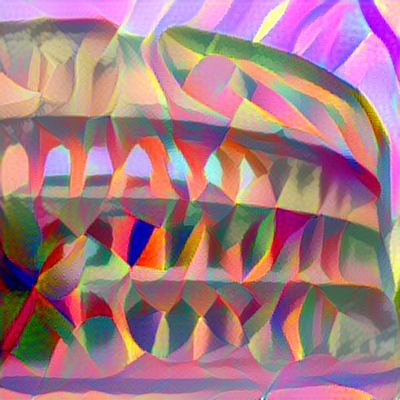

Iteration 100: loss=1933.10
Iteration 200: loss=1933.07
Iteration 300: loss=1933.04
Iteration 400: loss=1933.02
Iteration 500: loss=1932.99
Iteration 600: loss=1932.97
Iteration 700: loss=1932.95
Iteration 800: loss=1932.92
Iteration 900: loss=1932.90
Iteration 1000: loss=1932.88
Iteration 1100: loss=1932.87
Iteration 1200: loss=1932.85
Iteration 1300: loss=1932.83
Iteration 1400: loss=1932.81
Iteration 1500: loss=1932.80
Iteration 1600: loss=1932.78
Iteration 1700: loss=1932.77
Iteration 1800: loss=1932.76
Iteration 1900: loss=1932.74
Iteration 2000: loss=1932.73
Iteration 2100: loss=1932.72
Iteration 2200: loss=1932.71
Iteration 2300: loss=1932.70
Iteration 2400: loss=1932.69
Iteration 2500: loss=1932.68
Iteration 2600: loss=1932.67
Iteration 2700: loss=1932.66
Iteration 2800: loss=1932.65
Time:  497.04 sek for  2800  iterations
Photo name:  paris_generated_at_iteration_2800.png


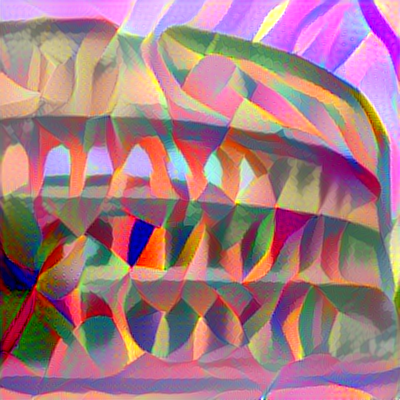

Iteration 100: loss=1932.65
Iteration 200: loss=1932.64
Iteration 300: loss=1932.63
Iteration 400: loss=1932.63
Iteration 500: loss=1932.62
Iteration 600: loss=1932.61
Iteration 700: loss=1932.61
Iteration 800: loss=1932.60
Iteration 900: loss=1932.60
Iteration 1000: loss=1932.59
Iteration 1100: loss=1932.59
Iteration 1200: loss=1932.59
Iteration 1300: loss=1932.58
Iteration 1400: loss=1932.58
Iteration 1500: loss=1932.58
Iteration 1600: loss=1932.57
Iteration 1700: loss=1932.57
Iteration 1800: loss=1932.57
Iteration 1900: loss=1932.57
Iteration 2000: loss=1932.56
Iteration 2100: loss=1932.56
Iteration 2200: loss=1932.56
Iteration 2300: loss=1932.56
Iteration 2400: loss=1932.56
Iteration 2500: loss=1932.55
Iteration 2600: loss=1932.55
Iteration 2700: loss=1932.55
Iteration 2800: loss=1932.55
Iteration 2900: loss=1932.55
Iteration 3000: loss=1932.55
Time:  532.3 sek for  3000  iterations
Photo name:  paris_generated_at_iteration_3000.png


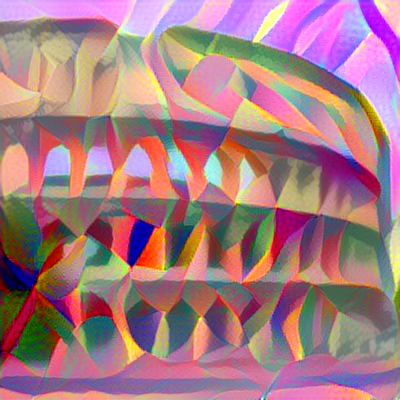

Iteration 100: loss=1932.55
Iteration 200: loss=1932.55
Iteration 300: loss=1932.55
Iteration 400: loss=1932.55
Iteration 500: loss=1932.54
Iteration 600: loss=1932.54
Iteration 700: loss=1932.54
Iteration 800: loss=1932.54
Iteration 900: loss=1932.54
Iteration 1000: loss=1932.54
Iteration 1100: loss=1932.54
Iteration 1200: loss=1932.54
Iteration 1300: loss=1932.54
Iteration 1400: loss=1932.54
Iteration 1500: loss=1932.54
Iteration 1600: loss=1932.54
Iteration 1700: loss=1932.54
Iteration 1800: loss=1932.54
Iteration 1900: loss=1932.54
Iteration 2000: loss=1932.54
Iteration 2100: loss=1932.54
Iteration 2200: loss=1932.54
Iteration 2300: loss=1932.54
Iteration 2400: loss=1932.54
Iteration 2500: loss=1932.54
Iteration 2600: loss=1932.54
Iteration 2700: loss=1932.54
Iteration 2800: loss=1932.54
Iteration 2900: loss=1932.54
Iteration 3000: loss=1932.54
Iteration 3100: loss=1932.54
Iteration 3200: loss=1932.54
Time:  567.81 sek for  3200  iterations
Photo name:  paris_generated_at_iteration

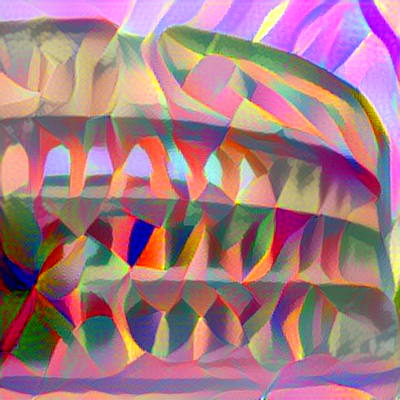

Iteration 100: loss=1932.54
Iteration 200: loss=1932.54
Iteration 300: loss=1932.54
Iteration 400: loss=1932.54
Iteration 500: loss=1932.54
Iteration 600: loss=1932.54
Iteration 700: loss=1932.54
Iteration 800: loss=1932.54
Iteration 900: loss=1932.54
Iteration 1000: loss=1932.54
Iteration 1100: loss=1932.54
Iteration 1200: loss=1932.54
Iteration 1300: loss=1932.54
Iteration 1400: loss=1932.54
Iteration 1500: loss=1932.54
Iteration 1600: loss=1932.54
Iteration 1700: loss=1932.54
Iteration 1800: loss=1932.54
Iteration 1900: loss=1932.54
Iteration 2000: loss=1932.54
Iteration 2100: loss=1932.54
Iteration 2200: loss=1932.54
Iteration 2300: loss=1932.54
Iteration 2400: loss=1932.54
Iteration 2500: loss=1932.54
Iteration 2600: loss=1932.54
Iteration 2700: loss=1932.54
Iteration 2800: loss=1932.54
Iteration 2900: loss=1932.54
Iteration 3000: loss=1932.54
Iteration 3100: loss=1932.54
Iteration 3200: loss=1932.54
Iteration 3300: loss=1932.54
Iteration 3400: loss=1932.54
Time:  603.42 sek for  

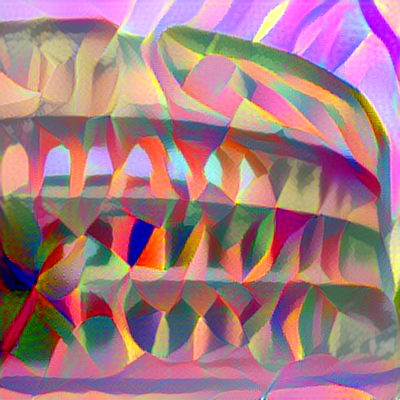

Iteration 100: loss=1932.54
Iteration 200: loss=1932.54
Iteration 300: loss=1932.54
Iteration 400: loss=1932.54
Iteration 500: loss=1932.54
Iteration 600: loss=1932.54
Iteration 700: loss=1932.54
Iteration 800: loss=1932.54
Iteration 900: loss=1932.54
Iteration 1000: loss=1932.54
Iteration 1100: loss=1932.54
Iteration 1200: loss=1932.54
Iteration 1300: loss=1932.54
Iteration 1400: loss=1932.54
Iteration 1500: loss=1932.54
Iteration 1600: loss=1932.54
Iteration 1700: loss=1932.54
Iteration 1800: loss=1932.54
Iteration 1900: loss=1932.54
Iteration 2000: loss=1932.54
Iteration 2100: loss=1932.54
Iteration 2200: loss=1932.54
Iteration 2300: loss=1932.54
Iteration 2400: loss=1932.54
Iteration 2500: loss=1932.54
Iteration 2600: loss=1932.54
Iteration 2700: loss=1932.54
Iteration 2800: loss=1932.54
Iteration 2900: loss=1932.54
Iteration 3000: loss=1932.54
Iteration 3100: loss=1932.54
Iteration 3200: loss=1932.54
Iteration 3300: loss=1932.54
Iteration 3400: loss=1932.54
Iteration 3500: loss=19

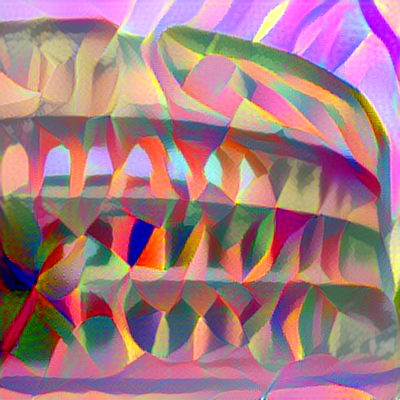

Iteration 100: loss=1932.54
Iteration 200: loss=1932.54
Iteration 300: loss=1932.54
Iteration 400: loss=1932.54
Iteration 500: loss=1932.54
Iteration 600: loss=1932.54
Iteration 700: loss=1932.54
Iteration 800: loss=1932.54
Iteration 900: loss=1932.54
Iteration 1000: loss=1932.54
Iteration 1100: loss=1932.54
Iteration 1200: loss=1932.54
Iteration 1300: loss=1932.54
Iteration 1400: loss=1932.54
Iteration 1500: loss=1932.54
Iteration 1600: loss=1932.54
Iteration 1700: loss=1932.54
Iteration 1800: loss=1932.54
Iteration 1900: loss=1932.54
Iteration 2000: loss=1932.54
Iteration 2100: loss=1932.54
Iteration 2200: loss=1932.54
Iteration 2300: loss=1932.54
Iteration 2400: loss=1932.54
Iteration 2500: loss=1932.54
Iteration 2600: loss=1932.54
Iteration 2700: loss=1932.54
Iteration 2800: loss=1932.54
Iteration 2900: loss=1932.54
Iteration 3000: loss=1932.54
Iteration 3100: loss=1932.54
Iteration 3200: loss=1932.54
Iteration 3300: loss=1932.54
Iteration 3400: loss=1932.54
Iteration 3500: loss=19

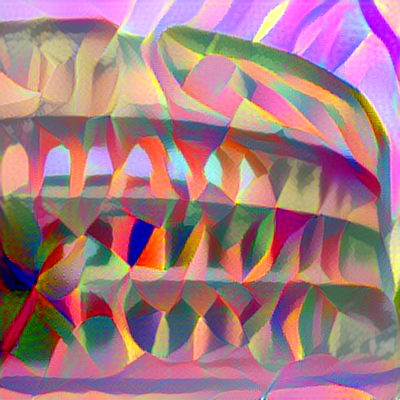

Iteration 100: loss=1932.54
Iteration 200: loss=1932.54
Iteration 300: loss=1932.54
Iteration 400: loss=1932.54
Iteration 500: loss=1932.54
Iteration 600: loss=1932.54
Iteration 700: loss=1932.54
Iteration 800: loss=1932.54
Iteration 900: loss=1932.54
Iteration 1000: loss=1932.54
Iteration 1100: loss=1932.54
Iteration 1200: loss=1932.54
Iteration 1300: loss=1932.54
Iteration 1400: loss=1932.54
Iteration 1500: loss=1932.54
Iteration 1600: loss=1932.54
Iteration 1700: loss=1932.54
Iteration 1800: loss=1932.54
Iteration 1900: loss=1932.54
Iteration 2000: loss=1932.54
Iteration 2100: loss=1932.54
Iteration 2200: loss=1932.54
Iteration 2300: loss=1932.54
Iteration 2400: loss=1932.54
Iteration 2500: loss=1932.54
Iteration 2600: loss=1932.54
Iteration 2700: loss=1932.54
Iteration 2800: loss=1932.54
Iteration 2900: loss=1932.54
Iteration 3000: loss=1932.54
Iteration 3100: loss=1932.54
Iteration 3200: loss=1932.54
Iteration 3300: loss=1932.54
Iteration 3400: loss=1932.54
Iteration 3500: loss=19

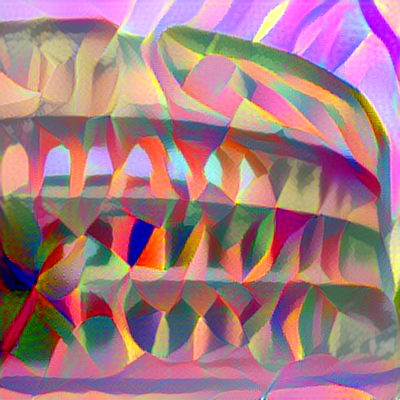

In [58]:
import time
for ii in range(20):
    start = time.time()
    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
        if i % 100 == 0:
            print("Iteration %d: loss=%.2f" % (i, loss))
            img = deprocess_image(combination_image.numpy())
            fname = result_prefix + "_at_iteration_%d.png" % i
            keras.preprocessing.image.save_img(fname, img)
    end = time.time()
    print("Time: ",round(end-start,2),"sek for ",iterations," iterations")
    print("Photo name: ",fname)
    display(Image(result_prefix + "_at_iteration_%d.png" % i))
    iterations+=200


In [59]:
display(Image(result_prefix + "_at_iteration2000_.png"))
